# Neural Quest Assignment-1
*  In this assignment, we will build a classifier for MNIST from scratch using just [NumPy](https://numpy.org/)

*  [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits of size 28x28

*  The dataset that you are expected to use for training can be found [here](https://drive.google.com/file/d/1DF-OWSP803x34FrvaJ4XeDm_QZUevu32/view?usp=sharing)

*   Our model will have 1 hidden layer, like the one below (not our recommendation to use 256 in the hidden layer though, try various values out)

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

<center>
<img src="https://user-images.githubusercontent.com/81357954/166119893-4ca347b8-b1a4-40b8-9e0a-2e92b5f164ae.png">
</center>

## Import libraries here
NumPy, Matplotlib, ...

Also remember to initialize the seed for reproducibility of results

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import MinMaxScaler
np.random.seed(69)

## Load *Dataset*
Load data from the given pickle file

In [17]:
# mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# load the data set
with open('/content/drive/MyDrive/soc/train_data.pkl', 'rb') as f:
    data = pickle.load(f)
X = data['X']
y = data['y']

# normalize
scale = MinMaxScaler()
X_normalized = scale.fit_transform(X)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


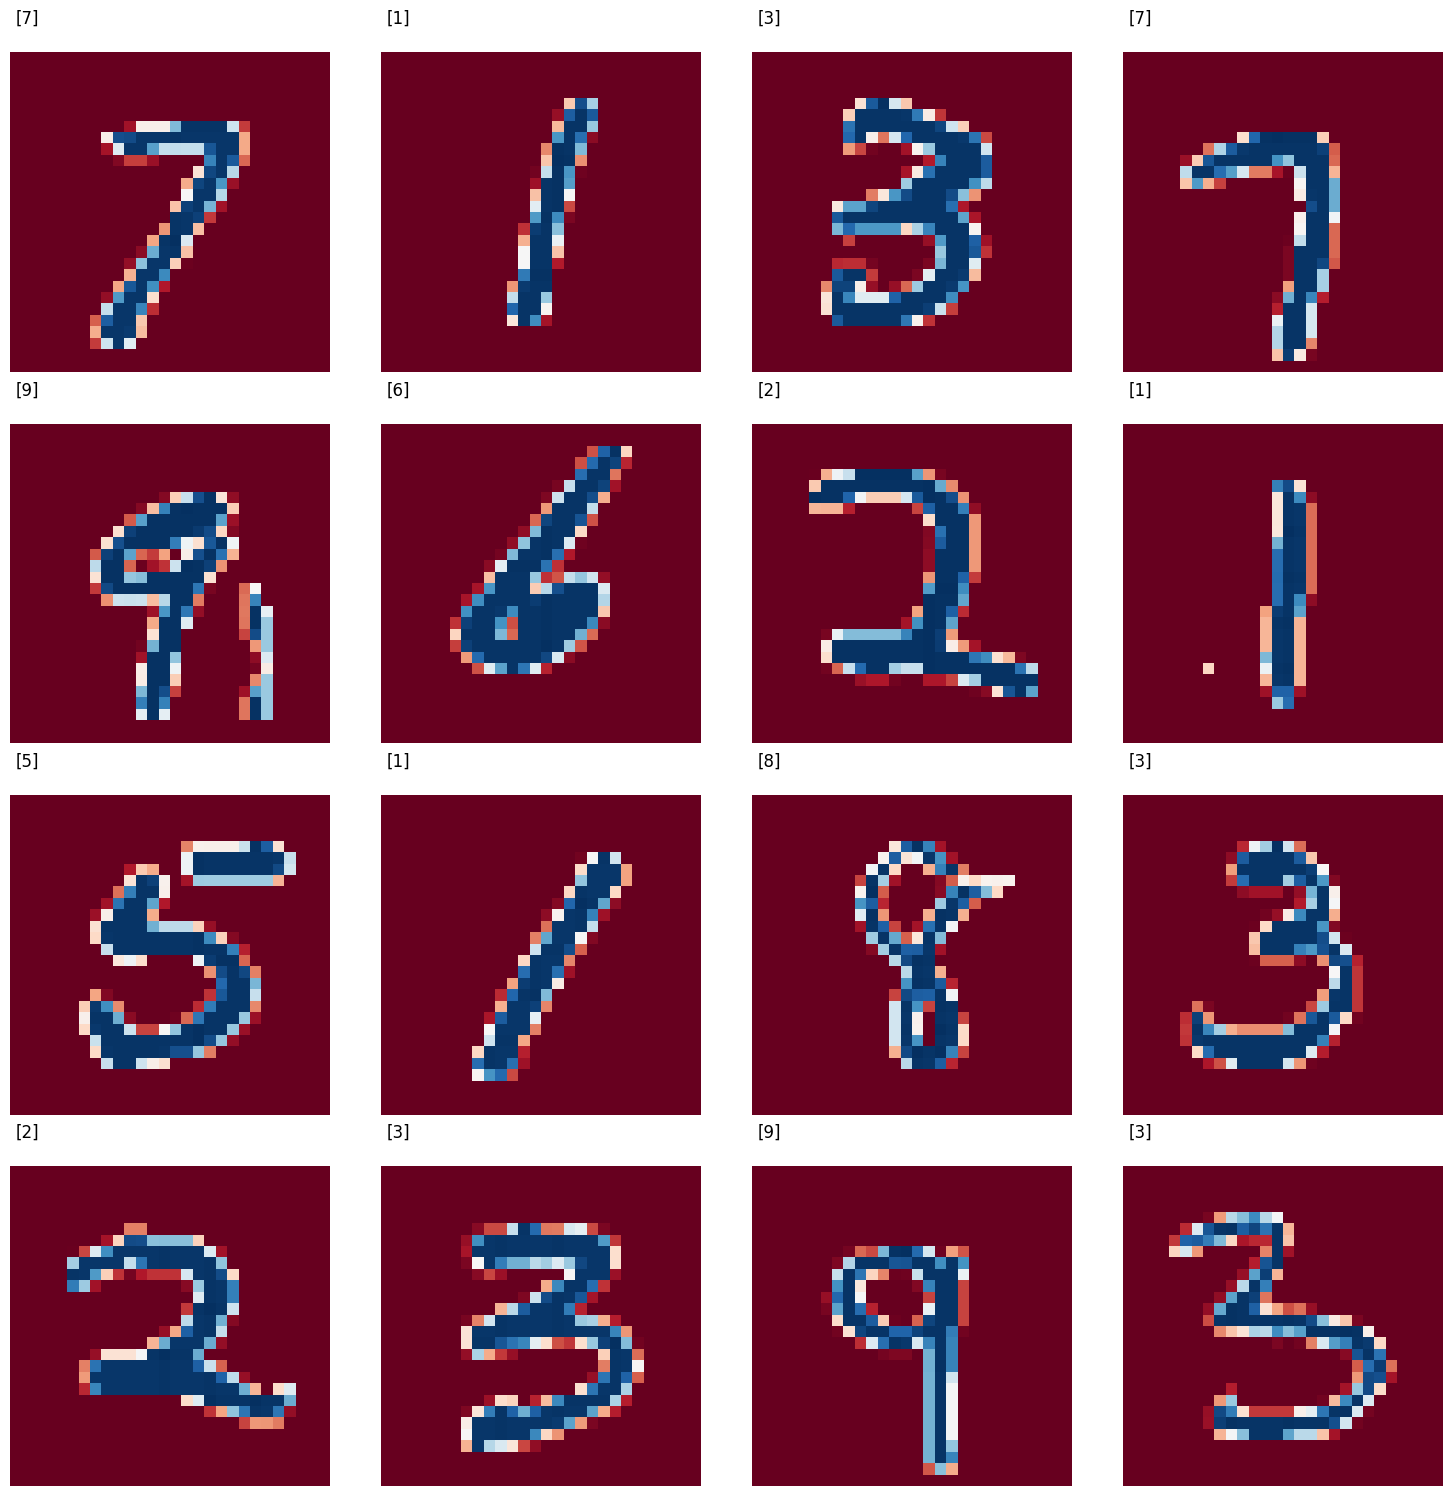

In [18]:
# display a 4x4 grid,
# choose 16 images randomly, display the images as well as corresponding labels
num_samples_to_display = 16
random_indices = np.random.choice(len(X_train), num_samples_to_display, replace=False)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
axes = axes.flatten()
for i, idx in enumerate(random_indices):
    ax = axes[i]
    images = X_train[idx]
    pixels = images.reshape((28,28))
    ax.imshow(pixels, cmap='RdBu')
    ax.text(0,-3,y_train[idx],fontsize=12)
    ax.axis('off')
plt.tight_layout()
plt.show()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

## Building up parts of our classifier

**Activation functions**

In [19]:
def relu(z):
    """
    Arguments:
    z -- A scalar or numpy array.
    Return:
    relu func applied to each element of z
    """
    return np.maximum(0,z)

def softmax(z):
    """
    returns computed probabilitites for each element in batch separately
    input: (N, 10)
    output: (N, 10)
    """
    A = np.exp(z) / sum(np.exp(z))
    return A

**Notes about the Neural Network**
*   Input size is (784,) because 28x28 = 784
*   Output size will be 10, each element represeting probability of the image representing that digit
*   Size of the hidden layer is a hyperparameter



**Initialize the layers weights**

Generally, we follow the convention that weights are drawn from a standard normal distribution, while the bias vectors are initialized to zero. But you can try everything out :)

In [20]:
def init_params(n_hidden):
    """
    ideally it should take the size of all the layers and
    should return the initialized weights.
    """
    W1 = np.random.randn(n_hidden,784)
    W2 = np.random.randn(10,n_hidden)
    b1 = np.zeros((n_hidden,1))
    b2 = np.zeros((10,1))
    return W1,b1,W2,b2

**Forward Propagation**

In [21]:
def forward_propg(W1,b1,W2,b2,X):
    """
    X: input data
    returns: logits, output of each layer z1,z2,a1,a2
    """
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    Z2 = W2.dot(Z1) + b2
    A2 = softmax(Z2)
    return Z1,A1,Z2,A2

**Backward Propagation**


You may use stochastic gradient descent or batch gradient descent here. Feel free to use any loss function.

In [22]:
def y_data(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def d_relu(Z):
    return Z>0

def backward_propg(Z1,A1,Z2,A2,W2,X,Y):
    """
    should update the weights and return updated weights
    """
    y= y_data(Y)
    dz2 = A2 - y
    dw2 = dz2.dot(A1.T)/Y.size
    db2 = np.sum(dz2)/Y.size
    dz1 = W2.T.dot(dz2)*d_relu(Z1)
    dw1 = dz1.dot(X.T)/Y.size
    db1 = np.sum(dz1)/Y.size
    return dw1,db1,dw2,db2

def update_params(w1,dw1,w2,dw2,b1,db1,b2,db2,a):
    w1 = w1 - a*dw1
    b1 = b1 - a*db1
    w2 = w2 - a*dw2
    b2 = b2 - a*db2
    return w1,b1,w2,b2

In [23]:
def cost_func(y_pred, y):
    """
    calculate loss to check whether it is decreasing at each epoch or not
    one can return this in backward propagation as well
    """
    epsilon = 1e-8
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.mean(y * np.log(y_pred))
    return loss


## Integrate everything

In [24]:
def pred(A2):
    return np.argmax(A2,axis=0)

def accuracy(predict,y):
    return (np.sum(predict==y)/y.size)

def train(X, Y, epochs, lr, n_hidden):
    """
    hidden_nodes: no. of nodes in hidden layer

    should return the updated optimize weights.
    """
    # initialize weights.
    w1,b1,w2,b2 = init_params(n_hidden)
    for i in range(epochs):
        # forward propagation
        z1,a1,z2,a2 = forward_propg(w1,b1,w2,b2,X)
        # backward propagation
        dw1,db1,dw2,db2 = backward_propg(z1,a1,z2,a2,w2,X,Y)
        w1,b1,w2,b2 = update_params(w1,dw1,w2,dw2,b1,db1,b2,db2,lr)
        #print cost function
        if i%100 ==0:
            print(f"Iteration = {i}   Loss = {cost_func(pred(a2),Y.reshape(-1))}")
    return w1,b1,w2,b2

In [25]:
def predict(X, w1,b1,w2,b2):
    """
    returns the prediction in [0,9] for each element in X
    """
    _,_,_,a2 = forward_propg(w1,b1,w2,b2,X)
    return np.argmax(a2, axis=0)

In [26]:
def accuracy(predictions, y):
    """
    prints % accuracy
    """
    num_correct = np.sum(predictions == y)
    accuracy = 100 * num_correct / y.shape[0]
    print(f"Accuracy: {accuracy}%")

In [31]:
w1,b1,w2,b2 = train(X_train,y_train,1001,0.05,256)

Iteration = 0   Loss = 7.2942058509379715
Iteration = 100   Loss = 1.5162523273882464
Iteration = 200   Loss = 1.077993631592963
Iteration = 300   Loss = 0.9033809288023728
Iteration = 400   Loss = 0.811277525132611
Iteration = 500   Loss = 0.7709822860270903
Iteration = 600   Loss = 0.704207318366513
Iteration = 700   Loss = 0.6965320347273661
Iteration = 800   Loss = 0.672738655446011
Iteration = 900   Loss = 0.6888567510882193
Iteration = 1000   Loss = 0.6623770225331627


In [32]:
prediction=predict(X_test,w1,b1,w2,b2)
accuracy(prediction,y_test.reshape(-1))

Accuracy: 85.1%


### Save as pickle

In [33]:
import pickle
import random
from google.colab import files

roll_num = "22B1236" # enter ldap
hidden_dim = 256 # replace with your own hidden dimension

model_dict = {
    'z': hidden_dim, # hidden dimension of your model
    'layer_0_wt': w1, # layer 0 weight (784, z)
    'layer_0_bias': b1, # layer 0 bias (z, 1)
    'layer_1_wt': w2, # layer 1 weight (z, 10)
    'layer_1_bias': b2 # layer 1 bias (10, 1)
}

assert model_dict['layer_0_wt'].shape == (hidden_dim, 784)
assert model_dict['layer_0_bias'].shape == (hidden_dim, 1)
assert model_dict['layer_1_wt'].shape == (10, hidden_dim)
assert model_dict['layer_1_bias'].shape == (10, 1)

with open(f'model_{roll_num}.pkl', 'wb') as f:
    pickle.dump(model_dict, f)
    files.download(f'model_{roll_num}.pkl') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>